In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [30]:
df=pd.read_csv("../Data.csv",index_col="Date")
df.index=pd.to_datetime(df.index)

In [31]:
close_series = df['Close']


In [32]:
close_series

Date
2020-02-10     78.119225
2020-02-11     77.647942
2020-02-12     79.491882
2020-02-13     78.925804
2020-02-14     78.945267
                 ...    
2025-02-03    228.009995
2025-02-04    232.800003
2025-02-05    232.470001
2025-02-06    233.220001
2025-02-07    227.630005
Name: Close, Length: 1257, dtype: float64

In [33]:
Close_diff = close_series.diff()
Close_diff = close_series.dropna()


In [34]:
def adf_test(series):
    series = series.dropna()

    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("✅ Données stationnaires")
    else:
        print("❌ Données NON stationnaires")

In [35]:
adf_test(close_series)


ADF Statistic: -1.2488412420527693
p-value: 0.6522407546965566
❌ Données NON stationnaires


In [36]:
adf_test(Close_diff)


ADF Statistic: -1.2488412420527693
p-value: 0.6522407546965566
❌ Données NON stationnaires


In [38]:
Close_diff2 = Close_diff.diff().dropna()
print("\nÉtape 3: Deuxième différenciation")
adf_test(Close_diff2)


Étape 3: Deuxième différenciation
ADF Statistic: -35.94329036937647
p-value: 0.0
✅ Données stationnaires


In [50]:
Close_diff2

Date
2020-02-11   -0.471283
2020-02-12    1.843941
2020-02-13   -0.566078
2020-02-14    0.019463
2020-02-18   -1.445541
                ...   
2025-02-03   -7.990005
2025-02-04    4.790009
2025-02-05   -0.330002
2025-02-06    0.750000
2025-02-07   -5.589996
Name: Close, Length: 1256, dtype: float64

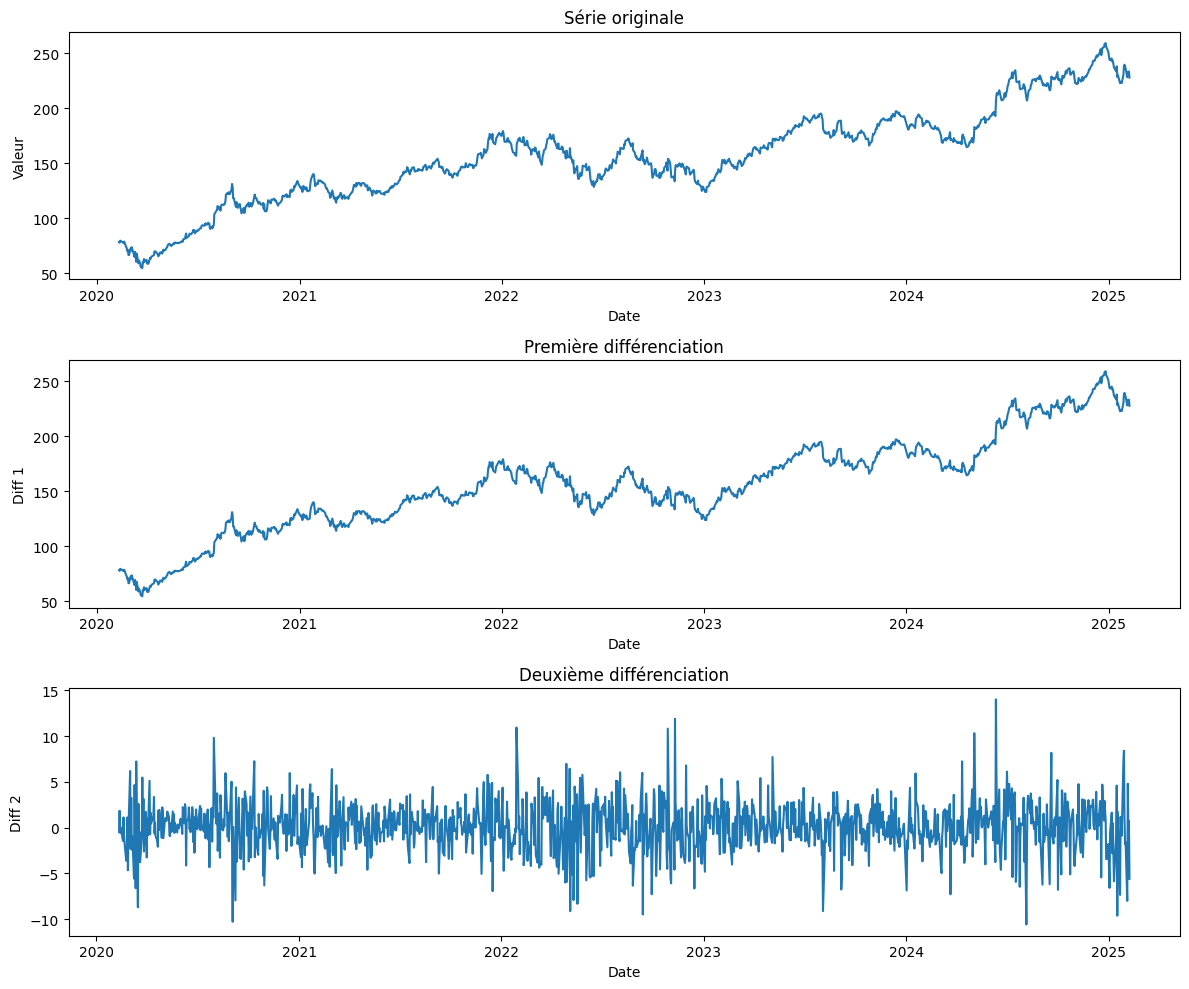

In [43]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Série originale
ax1.plot(close_series)
ax1.set_title('Série originale')
ax1.set_xlabel('Date')
ax1.set_ylabel('Valeur')

# Première différenciation
ax2.plot(Close_diff)
ax2.set_title('Première différenciation')
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff 1')

# Deuxième différenciation
ax3.plot(Close_diff2)
ax3.set_title('Deuxième différenciation')
ax3.set_xlabel('Date')
ax3.set_ylabel('Diff 2')

plt.tight_layout()
plt.show()


In [54]:
# 🎯 2. Division Train/Test

train_data=Close_diff2[0:int(len(Close_diff2)*0.8)]
test_data=Close_diff2[int(len(Close_diff2)*0.8):len(Close_diff2)]


In [65]:
train_data 

Date
2020-02-11   -0.471283
2020-02-12    1.843941
2020-02-13   -0.566078
2020-02-14    0.019463
2020-02-18   -1.445541
                ...   
2024-01-31   -3.622238
2024-02-01    2.448013
2024-02-02   -1.005066
2024-02-05    1.821060
2024-02-06    1.612106
Name: Close, Length: 1004, dtype: float64

In [66]:
test_data

Date
2024-02-07    0.109482
2024-02-08   -1.084702
2024-02-09    0.767227
2024-02-12   -1.693878
2024-02-13   -2.102402
                ...   
2025-02-03   -7.990005
2025-02-04    4.790009
2025-02-05   -0.330002
2025-02-06    0.750000
2025-02-07   -5.589996
Name: Close, Length: 252, dtype: float64

<Figure size 800x400 with 0 Axes>

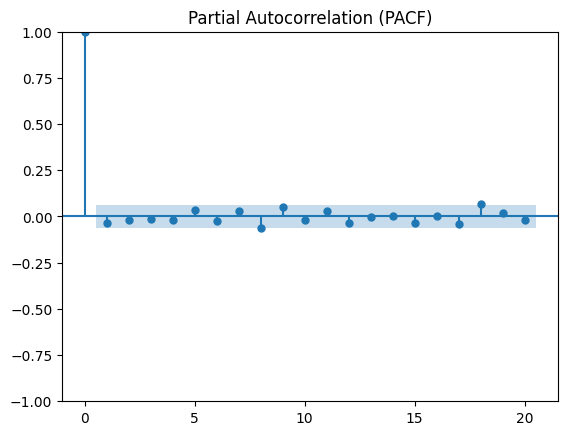

In [56]:
# 🎯 3. Analyse PACF pour déterminer `p`
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(8,4))
plot_pacf(train_data, lags=20, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()

lag = 1

In [57]:
# 🎯 4. Modèle AutoReg (AR) avec lag=1
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train_data, lags=1)
model_fit = model.fit()
coef = model_fit.params
print("\n📌 Coefficients du modèle AR(1) :\n", coef)





📌 Coefficients du modèle AR(1) :
 const       0.114058
Close.L1   -0.033784
dtype: float64


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [62]:

# 🎯 5a. Prédiction avec `predict()`
predictions1 = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
results = pd.DataFrame({
    'Predicted': predictions1,
    'Expected': test_data
}, index=test_data.index)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [64]:
# Afficher les premières comparaisons
print("Comparaison des 10 premières prédictions vs valeurs réelles:")
print(results.head(10))

Comparaison des 10 premières prédictions vs valeurs réelles:
            Predicted  Expected
Date                           
2024-02-07        NaN  0.109482
2024-02-08        NaN -1.084702
2024-02-09        NaN  0.767227
2024-02-12        NaN -1.693878
2024-02-13        NaN -2.102402
2024-02-14        NaN -0.886795
2024-02-15        NaN -0.288940
2024-02-16        NaN -1.544434
2024-02-20        NaN -0.747284
2024-02-21        NaN  0.757278
